<a href="https://colab.research.google.com/github/RuaanV/datascience-notebook/blob/master/cnn_mario_image_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Excercising CNN code base on the Medium article -  [Mario vs. Wario — round 2: CNNs in PyTorch and Google Colab](https://towardsdatascience.com/mario-vs-wario-round-2-cnns-in-pytorch-and-google-colab-48b968cf4ace)

In [2]:
# inspect the os 
!cat /etc/*-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.1 LTS"
NAME="Ubuntu"
VERSION="18.04.1 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.1 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [3]:
# inspect GPU and RAM ----

# memory footprint support libraries/code
!pip install gputil
!pip install psutil
!pip install humanize

import GPUtil as GPU
import os
import humanize
import psutil
!ln - sf / opt/bin/nvidia-smi / usr/bin/nvidia-smi

GPUs = GPU.getGPUs()
gpu = GPUs[0]


def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available),
          " | Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(
        gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
ln: target 'usr/bin/nvidia-smi' is not a directory
Gen RAM Free: 12.8 GB  | Proc size: 352.5 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


Install the libraries used in these code snippets

In [47]:
!pip3 install pytube
!pip3 install lime

# Loading libraries ----

# misc
import os
import shutil
from random import sample, randint, shuffle
import math
import numpy as np
import pandas as pd
from skimage.segmentation import mark_boundaries

# sci-kit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# youtube
from pytube import YouTube

# image operation
import cv2
from PIL import Image

# keras 
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import inception_v3 as inc_net

# lime
import lime
from lime import lime_image

print('Notebook run using keras:', keras.__version__)

mario_training_path = "/content/gdrive/My Drive/training_set/mario/"
wario_training_path = "/content/gdrive/My Drive/training_set/wario/"

mario_test_path = "/content/gdrive/My Drive/test_set/mario/"
wario_test_path = "/content/gdrive/My Drive/test_set/wario/"

Notebook run using keras: 2.2.4


In [50]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# UDFs ----

def scrape_frames(video_name, dest_path, n_images, skip_seconds, img_name):
    # function for scraping frames from videos
    vidcap = cv2.VideoCapture(video_name)
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    every_x_frame = math.floor((total_frames - skip_seconds * fps) / n_images) - 1

    success,image = vidcap.read()
    frame_count = 0
    img_count = 0
    
    while success: 
        success,image = vidcap.read() #success might be false and image might be None
        
        if frame_count > (skip_seconds * 30):
            # break if the video ended
            if not success:
                break

            # action on every x-th frame 
            if (frame_count % every_x_frame == 0):
                write_path = dest_path + img_name + "_" + str(img_count) + '.jpg'
                cv2.imwrite(write_path, image)   
                img_count += 1
                if (round(img_count / n_images, 2) * 100 % 10 == 0): 
                    print("Completed:", round(img_count / n_images, 2), "done.", end="\r")

            if img_count == n_images:
                break   
            
        frame_count += 1
#         print(write_path)
        
def move_random_files(path_from, path_to, n):
    # function for moving random files from one directory to another (used for creating train and test set)
    files = os.listdir(path_from)
    files.sort()
    files = files[1:] #omiting .DS_Store

    for i in sample(range(0, len(files)-1), n):
        f = files[i]
        src = path_from + f
        dst = path_to + f
        shutil.move(src, dst)
        
def preview_random_image(path):
    # function for previewing a random image from a given directory
    files = os.listdir(path)
    files.sort()
    img_name = files[randint(1, len(files) - 1)]
    img_preview_name = path + img_name
    image = Image.open(img_preview_name)
    plt.imshow(image)
    plt.title(img_name)
    plt.show()
    width, height = image.size
    print ("Dimensions:", image.size, "Total pixels:", width * height)
    
def pretty_cm(y_pred, y_truth, labels):
    # pretty implementation of a confusion matrix
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    # labels, title and ticks
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Accuracy: {0}'.format(metrics.accuracy_score(y_truth, y_pred)), size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
def img_to_1d_greyscale(img_path, size):
    # function for loading, resizing and converting an image into greyscale
    # used for logistic regression
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return(pd.Series(img.flatten()))

def show_image(image):
    # function for viewing an image
    fig = plt.figure(figsize = (5, 25))
    ax = fig.add_subplot(111)
    ax.imshow(image, interpolation='none')
    plt.show()

def transform_image(path, size):
    # function for transforming images into a format supported by CNN
    x = load_img(path, target_size=(size[0], size[1]))
    x = img_to_array(x) / 255
    x = np.expand_dims(x, axis=0)
    return (x)

def evaluation_indices(y_pred, y_test):
    # function for getting correctly and incorrectly classified indices
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)

Downloading **YouTube** clip

In [22]:
mario_video = YouTube('https://www.youtube.com/watch?v=lXMJt5PP3kM')

# viewing available video formats 
print('Title:', mario_video.title, '---')
stream = mario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)
    
# downloading the video
mario_video.streams.get_by_itag(18).download("/content/gdrive/My Drive/")

Title: Game Boy Longplay [005] Super Mario Land 2: 6 Golden Coins ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


'/content/gdrive/My Drive/Game Boy Longplay [005] Super Mario Land 2 6 Golden Coins.mp4'

In [23]:
wario_video = YouTube('https://www.youtube.com/watch?v=ZJuxdR0KH-s')
# viewing available video formats 
print('Title:', wario_video.title, '---')
stream = wario_video.streams.filter(file_extension = "mp4").all()
for i in stream:
    print(i)
    
# downloading the video
wario_video.streams.get_by_itag(18).download("/content/gdrive/My Drive/")

Title: Game Boy Longplay [004] Super Mario Land 3: Wario Land ---
<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2">
<Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400d">
<Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400b">
<Stream: itag="140" mime_type="audio/mp4" abr="128kbps" acodec="mp4a.40.2">


'/content/gdrive/My Drive/Game Boy Longplay [004] Super Mario Land 3 Wario Land.mp4'

Cut the frames from the video

In [17]:
!ls '/content/'

'Game Boy Longplay [004] Super Mario Land 3 Wario Land.mp4'	  gdrive
'Game Boy Longplay [005] Super Mario Land 2 6 Golden Coins.mp4'   sample_data


In [55]:
# getting frames from Mario
scrape_frames("Game Boy Longplay [005] Super Mario Land 2 6 Golden Coins.mp4", 
              "/content/gdrive/My Drive/training_set/mario/",
               
              n_images = 5000,
              skip_seconds = 60,
             img_name = "mario")

# removed parameter - every_x_frame = 50,

In [61]:
# getting frames from Wario
scrape_frames("Game Boy Longplay [004] Super Mario Land 3 Wario Land.mp4", 
              "/content/gdrive/My Drive/training_set/wario/",
               
              n_images = 5000,
              skip_seconds = 60,
             img_name = 'wario')

# removed parameter - every_x_frame = 50,

## Data preprocessing

## Splitting data into training and test sets

Mount Google drive to store images

In [0]:
move_random_files(path_from = mario_training_path, 
                  path_to = mario_test_path, 
                  n = 1000)

In [0]:

move_random_files(path_from = wario_training_path, 
                  path_to = wario_test_path, 
                  n = 1000)

## Previewing Images that have been scraped from the videos

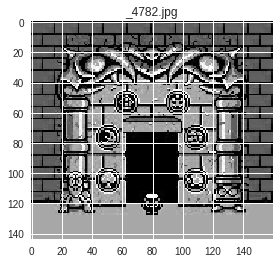

Dimensions: (160, 144) Total pixels: 23040


In [27]:
# Mario images
preview_random_image("/content/gdrive/My Drive/training_set/mario/")

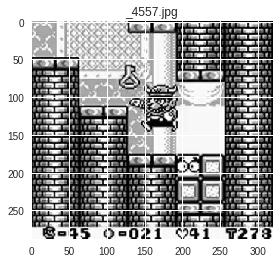

Dimensions: (320, 288) Total pixels: 92160


In [28]:
# Wario images
preview_random_image("/content/gdrive/My Drive/training_set/wario/")

Checking Keras vs OpenCV

FileNotFoundError: ignored

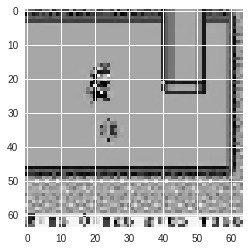

In [35]:
im = cv2.imread(mario_test_path + '_2.jpg')
plt.imshow(im)

# using openCV
im_cv = cv2.resize(im, (64, 64)) 
plt.imshow(im_cv)

# using a function from Keras
im = load_img('training_set/mario/mario_1.jpg', target_size=(64, 64))
plt.imshow(im)

In [0]:
!nvidia-smi

In [0]:
!nvcc --version

Fetch the images files and store them in my Google drive

In [0]:
!pip install gdown

# create directory for storing data
!mkdir -p data

# download zip file with training set
!gdown https://drive.google.com/uc?id=1z_vO2muBgzNGIa7JtY8OPmaeUC348jj4 && unzip -qq training_set.zip -d data/training_set
!rm training_set.zip

# download zip with test set
!gdown https://drive.google.com/uc?id=1ziwxAVrbDRfUTYMrFu0sn1B8OH-6gvej && unzip -qq test_set.zip -d data/test_set
!rm test_set.zip

# remove some leftover dir
!rm -r /content/data/test_set/__MACOSX/

# change dir to the one with data 
!cd /content/data

In [0]:
# change dir to the one with data 
!cd /content/data

In [0]:
!pip3 install torch torchvision

Loading data

In [0]:
import torch
import numpy as np
from torchvision import transforms
from torchvision import datasets

# 1. defining parameters ----

# number of subprocesses to use for data loading
num_workers = 0
# number of samples to load per batch
batch_size = 32
# % of training set to use as validation
valid_size = 0.2

# define transformations that will be applied to images
image_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 2. define the datasets ----
train_data = datasets.ImageFolder(root='data/training_set/', transform=image_transforms)
test_data = datasets.ImageFolder(root='data/test_set/', transform=image_transforms)

# 3. obtain indices that will be used for validation ----
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# 4. prepare data loaders (combine dataset with sampler) ----
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           sampler = train_sampler, 
                                           num_workers = num_workers,
                                           pin_memory = pin_memory)
valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size, 
                                           sampler = valid_sampler, 
                                           num_workers = num_workers,
                                           pin_memory = pin_memory)
test_loader = torch.utils.data.DataLoader(test_data,
                                          shuffle = True,
                                          batch_size = batch_size, 
                                          num_workers = num_workers,
                                          pin_memory = pin_memory)

# specify the image classes ----
classes = ['mario', 'wario']

NameError: ignored